In [1]:
%load_ext autoreload
%autoreload 2

In [160]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix, classification_report
from torch.utils.data import DataLoader, random_split
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image



In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
torch.manual_seed(100)
if torch.cuda.is_available():
    torch.cuda.manual_seed(100)

In [46]:
import kagglehub

path = kagglehub.dataset_download("cmglonly/simple-dinosurus-dataset")

print("Path to dataset files:", path)

100%|██████████| 55.5M/55.5M [00:05<00:00, 11.1MB/s]

Extracting files...


Path to dataset files: C:\Users\Tobias\.cache\kagglehub\datasets\cmglonly\simple-dinosurus-dataset\versions\1


In [97]:
image_mean = [0.485, 0.456, 0.406]
image_std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(image_mean, image_std),
])


val_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(image_mean, image_std),
])


#dataset = datasets.ImageFolder(os.path.join(path, "sharks"))
dataset = datasets.ImageFolder(path)

Split between train and eval data

In [99]:
train_size = int(len(dataset) * 0.8)
val_size = len(dataset) - train_size


train_data, val_data = random_split(
    dataset, [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

train_data.dataset.transform = train_transform
val_data.dataset.transform = val_transform

In [100]:
batch_size = 32

loader_train = DataLoader(train_data, batch_size=batch_size, shuffle=True)
loader_val = DataLoader(val_data, batch_size=batch_size, shuffle=False)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0182073..2.64].


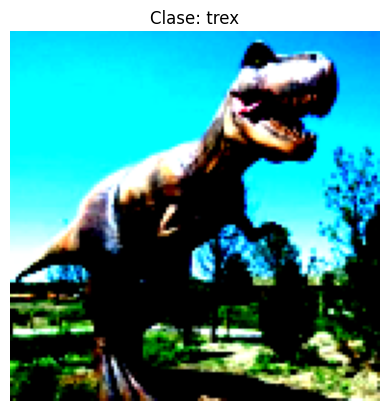

torch.Size([3, 128, 128])


In [101]:
img_tensor, label = dataset[130]
img_np = img_tensor.permute(1, 2, 0).numpy()

plt.imshow(img_np)
plt.title(f"Clase: {dataset.classes[label]}")
plt.axis('off')
plt.show()
print(img_tensor.size())

In [102]:
num_classes = len(dataset.classes)
num_classes

5

In [140]:
from cnn import CNN

In [141]:
model = CNN(num_classes=num_classes)

model = model.to(device)

In [142]:
learning_rate = 0.0001
momentum = 0.9

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = momentum)

In [143]:
NUM_EPOCHS = 15

for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    train_correct = 0
    total = 0

    for i, data in enumerate(loader_train, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.shape[0]
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_accuracy = 100 * train_correct / total
    running_loss = running_loss / total 

    val_correct = 0
    total = 0
    val_loss = 0
    with torch.no_grad():
        for data in loader_val:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            val_loss += criterion(outputs, labels).item() * images.shape[0]

    val_accuracy = 100 * val_correct / total
    val_loss = val_loss / total

    print(f'Epoch {epoch + 1} finished. Train accuracy: {train_accuracy:.2f}%. Validation accuracy: {val_accuracy:.2f}%. Validation Loss = {val_loss:.2f}')

print('Finished training.')


Epoch 1 finished. Train accuracy: 21.25%. Validation accuracy: 22.50%. Validation Loss = 1.63
Epoch 2 finished. Train accuracy: 25.62%. Validation accuracy: 22.50%. Validation Loss = 1.60
Epoch 3 finished. Train accuracy: 35.00%. Validation accuracy: 52.50%. Validation Loss = 1.46
Epoch 4 finished. Train accuracy: 60.62%. Validation accuracy: 52.50%. Validation Loss = 1.37
Epoch 5 finished. Train accuracy: 78.75%. Validation accuracy: 65.00%. Validation Loss = 1.31
Epoch 6 finished. Train accuracy: 85.62%. Validation accuracy: 62.50%. Validation Loss = 1.22
Epoch 7 finished. Train accuracy: 90.62%. Validation accuracy: 75.00%. Validation Loss = 1.13
Epoch 8 finished. Train accuracy: 90.00%. Validation accuracy: 77.50%. Validation Loss = 1.08
Epoch 9 finished. Train accuracy: 94.38%. Validation accuracy: 77.50%. Validation Loss = 1.03
Epoch 10 finished. Train accuracy: 93.75%. Validation accuracy: 87.50%. Validation Loss = 0.92
Epoch 11 finished. Train accuracy: 90.62%. Validation accur

Classification Report:

              precision    recall  f1-score   support

ankylosaurus       0.62      0.83      0.71         6
brontosaurus       1.00      0.80      0.89        10
 pterodactyl       0.80      0.80      0.80         5
        trex       1.00      1.00      1.00         9
 triceratops       0.80      0.80      0.80        10

    accuracy                           0.85        40
   macro avg       0.84      0.85      0.84        40
weighted avg       0.87      0.85      0.85        40



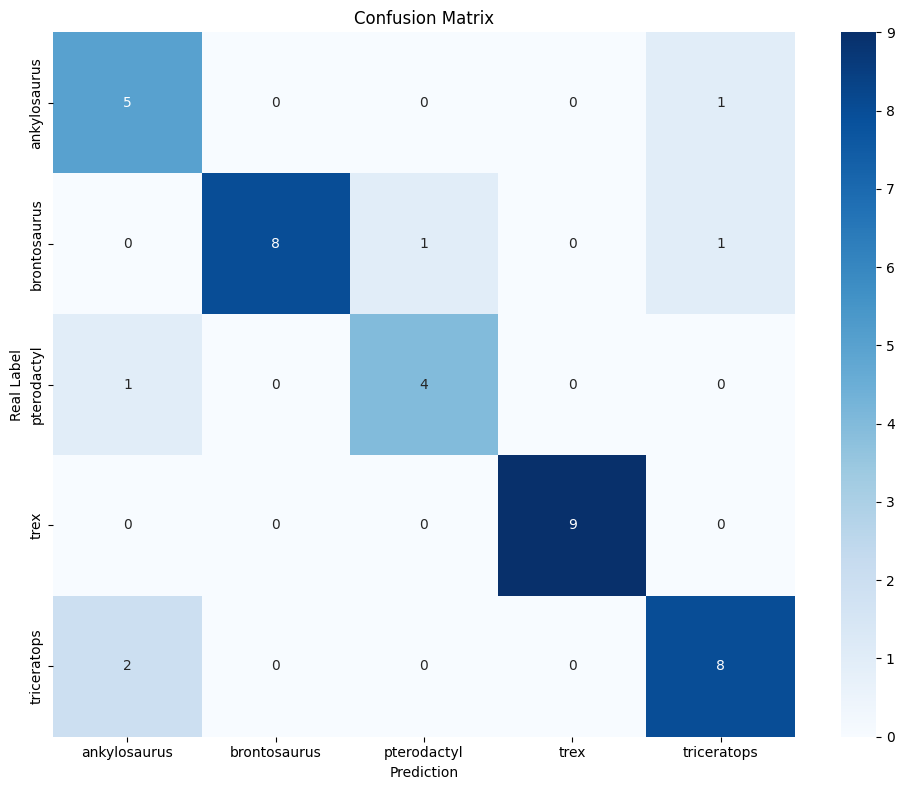

In [166]:
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for data in loader_val:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Nombres de las clases (ajustalo si tenés otra lista)
target_names = loader_val.dataset.dataset.classes  # <-- poné tus clases reales acá

cm = confusion_matrix(all_labels, all_preds)
print("Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=target_names))

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Prediction")
plt.ylabel("Real Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

In [116]:
def imshow(tensor, title=None):
    image = tensor.clone().detach().cpu()
    image = image.squeeze(0)  # quitar dimensión batch
    image = image * 0.5 + 0.5  # deshacer normalización (asumiendo mean=0.5, std=0.5)
    npimg = image.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5418272..1.82].


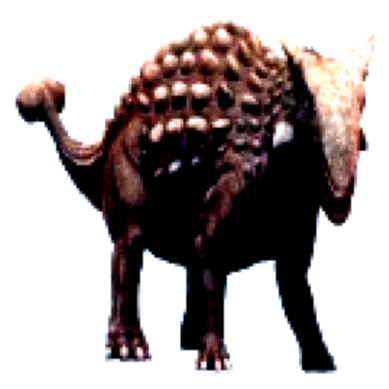

Original image mode: RGB, size: (317, 159)
Tensor shape before unsqueeze: torch.Size([3, 128, 128])


In [158]:
img_path = input("Input image path").strip('"').strip("'")

img = Image.open(img_path).convert('RGB')

img_tensor = val_transform(img)
img_tensor = img_tensor.float()
img_tensor = img_tensor.unsqueeze(0).to(device)

imshow(img_tensor)

print(f"Original image mode: {img.mode}, size: {img.size}")
print(f"Tensor shape before unsqueeze: {val_transform(img).shape}")



In [159]:
model.eval()

with torch.no_grad():
    prediction = model(img_tensor)
    _, predicted = torch.max(prediction, 1)

predicted_class_idx = predicted.item()
print(predicted_class_idx)
class_name = dataset.classes[predicted_class_idx]
print(f"Prediction: {class_name}")

4
Prediction: triceratops
